In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

In [15]:
def built_floor_feature(df_input):
    """
    所在階の中に{／}を含まないものの中から、現実的な長さのものを一軒家とみなす
    階層情報から、低層、高層、タワーマンションで分割
    
    """
    df_out = pd.DataFrame()

    df_out["building_floor"] = df_input["所在階"].str.split('／', expand=True)[1].str.split("（", expand=True)[0].str.replace('[^0-9]', '').fillna(0)
    df_out["building_floor"] = df_out["building_floor"].astype(int)

    return df_out


def built_year_feature(df_input):
    """築年数を年と月のnumericな特徴に分ける、新築フラグ"""
    df_out = pd.DataFrame()
    s = df_input["築年数"]
    df_out["int築年"] = [int(i.split('年')[0]) if "新築" not in i else 0 for i in s]
    
    return df_out

def modify_rent(target, df_input):
    """ id == 5776 で賃料の0が一つ多い"""
    target = np.where(df_input["id"]==5776, 120350, target)
    
    return target


In [16]:
'''setting'''
df = pd.read_csv('../../input/train.csv')
df = pd.concat([df, built_floor_feature(df), built_year_feature(df)], axis=1)
target = "所在地"

In [17]:
df = df.fillna("nan")
df["賃料"] = modify_rent(df["賃料"], df)

In [18]:
s_cut, bins =  pd.cut(df["賃料"], 10, labels=[i for i in range(10)], retbins=True)
#s_cut.value_counts()

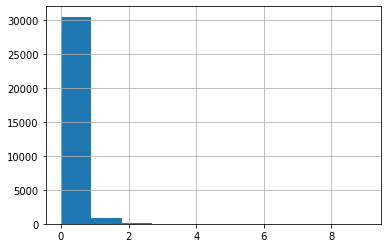

In [19]:
s_cut.hist()
df["same_build"] = df[['building_floor', "所在地", 'int築年']].astype(str).sum(axis=1)

In [20]:
df = df[df["賃料"]<300000].reset_index(drop=True)

## StratifiedKFold

In [21]:
#s_cut, bins =  pd.cut(df["賃料"], 10, labels=[i for i in range(10)], retbins=True)
#df["bin_target"] = s_cut
#df = df[df["賃料"]>100000].reset_index(drop=True)


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
df["fold_id"] = np.nan
for i, (train_index, valid_index) in enumerate(folds.split(df["id"], df["所在地"])):
    df.loc[valid_index, "fold_id"] = i
    try:
        df = df.drop("bin_target", axis=1)
    except:
        pass

df = df.drop(['building_floor', "int築年"], axis=1)
df.to_feather("../../input/mynavi_Stratifiedfold_access_under300000.feather")

/Users/ueda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [15]:
#df[["アクセス", "賃料", "fold_id"]]
df

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間,same_build,fold_id
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,12東京都北区滝野川３丁目9,1.0
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,nan,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,10東京都中央区月島３丁目44,1.0
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間,15東京都渋谷区笹塚２丁目8,1.0
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。,4東京都杉並区高円寺南２丁目23-229,0.0
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,nan,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間,2東京都葛飾区金町３丁目7-231,2.0
5,6,160000,東京都荒川区南千住５丁目,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,2LDK,7年6ヶ月,東,50.8m2,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間,12東京都荒川区南千住５丁目7,0.0
6,7,78500,東京都練馬区東大泉３丁目,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,1K,10年5ヶ月,南,23.82m2,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間,8東京都練馬区東大泉３丁目10,4.0
7,8,115000,東京都目黒区鷹番１丁目,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,1K,14年4ヶ月,nan,32.32m2,1階／6階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,nan,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間,6東京都目黒区鷹番１丁目14,2.0
8,9,184327,東京都文京区向丘１丁目,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,2DK,44年8ヶ月,北西,65.59m2,4階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,nan,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,nan,SRC（鉄骨鉄筋コンクリート）,2年間,9東京都文京区向丘１丁目44,4.0
9,10,76000,東京都板橋区板橋４丁目,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,1DK,38年9ヶ月,南東,30.3m2,2階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,光ファイバー／\tCATV,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,nan,鉄骨造,2年間,3東京都板橋区板橋４丁目38,4.0


## GroupKFold

In [70]:
#s_cut, bins =  pd.cut(df[target], 10, labels=[i for i in range(10)], retbins=True)
#df["bin_target"] = s_cut

folds = GroupKFold(n_splits=5)
X = df["id"].values
Y = df["アクセス"].values
groups = df["id"].values

df["fold_id"] = np.nan
for i, (train_index, valid_index) in enumerate(folds.split(X, Y, groups)):
    df.loc[valid_index, "fold_id"] = i

df.to_feather("../input/mynavi_GroupKfolds02.feather")

In [71]:
'''
with timer('takuoko lgbm modeling'):
        y_pred_t = np.empty(len_train,)
        y_test_t = []
        train_losses, valid_losses = [], []

        cv = GroupKFold(n_splits=n_splits)
        for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=y, groups=rescuer_id)): 
            X_train = X.loc[train_index, :]
            X_valid = X.loc[valid_index, :]
            y_train = y[train_index]
            y_valid = y[valid_index]
            
            
    

df = pd.read_csv('../input/train.csv')
s_cut, bins = pd.cut(df["sponsor_click"], 10, labels=[i for i in range(10)], retbins=True)
df["bin_target"] = s_cut

folds = GroupKFold(n_splits=5)
df["fold_id"] = np.nan
for i, (train_index, valid_index) in enumerate(folds.split(df["t_adv_id"], df["bin_target"], df["t_adv_id"])):
    df.loc[valid_index, "fold_id"] = i

df.to_feather("../input/atom_folds02.feather")
'''

'\nwith timer(\'takuoko lgbm modeling\'):\n        y_pred_t = np.empty(len_train,)\n        y_test_t = []\n        train_losses, valid_losses = [], []\n\n        cv = GroupKFold(n_splits=n_splits)\n        for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=y, groups=rescuer_id)): \n            X_train = X.loc[train_index, :]\n            X_valid = X.loc[valid_index, :]\n            y_train = y[train_index]\n            y_valid = y[valid_index]\n            \n            \n    \n\ndf = pd.read_csv(\'../input/train.csv\')\ns_cut, bins = pd.cut(df["sponsor_click"], 10, labels=[i for i in range(10)], retbins=True)\ndf["bin_target"] = s_cut\n\nfolds = GroupKFold(n_splits=5)\ndf["fold_id"] = np.nan\nfor i, (train_index, valid_index) in enumerate(folds.split(df["t_adv_id"], df["bin_target"], df["t_adv_id"])):\n    df.loc[valid_index, "fold_id"] = i\n\ndf.to_feather("../input/atom_folds02.feather")\n'

## StratifiedGroupKFold

In [ ]:
class StratifiedGroupKFold():
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        fold = pd.DataFrame([X, y, groups]).T
        fold.columns = ['X', 'y', 'groups']
        fold['y'] = fold['y'].astype(int)
        g = fold.groupby('groups')['y'].agg('mean').reset_index()
        fold = fold.merge(g, how='left', on='groups', suffixes=('', '_mean'))
        fold['y_mean'] = fold['y_mean'].apply(np.round)
        fold['fold_id'] = 0
        for unique_y in fold['y_mean'].unique():
            mask = fold.y_mean == unique_y
            selected = fold[mask].reset_index(drop=True)
            cv = GroupKFold(n_splits=self.n_splits)
            for i, (train_index, valid_index) in enumerate(
                    cv.split(range(len(selected)), y=None, groups=selected['groups'])):
                selected.loc[valid_index, 'fold_id'] = i
            fold.loc[mask, 'fold_id'] = selected['fold_id'].values

        for i in range(self.n_splits):
            indices = np.arange(len(fold))
            train_index = indices[fold['fold_id'] != i]
            valid_index = indices[fold['fold_id'] == i]
            yield train_index, valid_index

df = pd.read_csv('../input/train.csv')
s_cut, bins =  pd.cut(df["sponsor_click"], 10, labels=[i for i in range(10)], retbins=True)
df["bin_target"] = s_cut

folds = StratifiedGroupKFold(n_splits=5)
df["fold_id"] = np.nan
for i, (train_index, valid_index) in enumerate(folds.split(df["t_adv_id"], df["bin_target"], groups=df["t_adv_id"])):
    df.loc[valid_index, "fold_id"] = i

df.to_feather("../input/atom_folds03.feather")